In [0]:
!pip install livelossplot

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
##var url = "your_shareable_link_to_file"
##function getIdFromUrl(url) { return url.match(/[-\w]{25,}/); }
##getIdFromUrl(url)

In [0]:
downloaded = drive.CreateFile({'id':"15U9s4b0HH6qE-PggBVDGot9IYR7Q-CRb"})   # replace the id with id of file you want to access
downloaded.GetContentFile('cats-dogs.csv')


Delete the cats-dogs.zip and then rename cats-dogs.csv to cats-dogs.zip

In [11]:
!unzip cats-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation/cat/cat.1554.jpg  
  inflating: validation/cat/cat.1555.jpg  
  inflating: validation/cat/cat.1556.jpg  
  inflating: validation/cat/cat.1557.jpg  
  inflating: validation/cat/cat.1558.jpg  
  inflating: validation/cat/cat.1559.jpg  
  inflating: validation/cat/cat.1560.jpg  
  inflating: validation/cat/cat.1561.jpg  
  inflating: validation/cat/cat.1562.jpg  
  inflating: validation/cat/cat.1563.jpg  
  inflating: validation/cat/cat.1564.jpg  
  inflating: validation/cat/cat.1565.jpg  
  inflating: validation/cat/cat.1566.jpg  
  inflating: validation/cat/cat.1567.jpg  
  inflating: validation/cat/cat.1568.jpg  
  inflating: validation/cat/cat.1569.jpg  
  inflating: validation/cat/cat.1570.jpg  
  inflating: validation/cat/cat.1571.jpg  
  inflating: validation/cat/cat.1572.jpg  
  inflating: validation/cat/cat.1573.jpg  
  inflating: validation/cat/cat.1574.jpg  
  inflating: validation/cat/cat.1575.jpg  
  i

In [12]:
base_model=tf.keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [0]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "cats_vs_dogs.h5"

# Data
path = "/content/cats-dogs/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "testi" # 12 500

In [0]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [16]:
from keras.applications.mobilenet import preprocess_input
training_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
validation_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

Using TensorFlow backend.


In [20]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="categorical", 
    shuffle=False)

Found 20100 images belonging to 3 classes.
Found 5031 images belonging to 3 classes.
Found 100 images belonging to 1 classes.


In [0]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D

In [0]:
def create_model():
    
    model = tf.keras.models.Sequential([base_model])
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    return model

In [0]:
model = create_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 5,854,403
Trainable params: 5,832,515
Non-trainable params: 21,888
_________________________________________

In [0]:
base_model.trainable = False

In [0]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit(training_generator,
                              steps_per_epoch = len(training_generator.filenames) // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=validation_generator,
                              validation_steps = len(validation_generator.filenames) // BATCH_SIZE,
                             callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint(path+'/models/model_{epoch}_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')]
                   )

Epoch 1/20
628/628 [==============================] - 106s 169ms/step - loss: 0.0649 - accuracy: 0.9763 - val_loss: 0.0448 - val_accuracy: 0.9833
Epoch 2/20
628/628 [==============================] - 106s 168ms/step - loss: 0.0297 - accuracy: 0.9888 - val_loss: 0.0465 - val_accuracy: 0.9841
Epoch 3/20
628/628 [==============================] - 105s 167ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0638 - val_accuracy: 0.9783
Epoch 4/20
628/628 [==============================] - 104s 165ms/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 0.0454 - val_accuracy: 0.9843
Epoch 5/20
628/628 [==============================] - 105s 166ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 0.0464 - val_accuracy: 0.9859
Epoch 6/20
628/628 [==============================] - 104s 166ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0759 - val_accuracy: 0.9831
Epoch 7/20
628/628 [==============================] - 105s 167ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0647 -

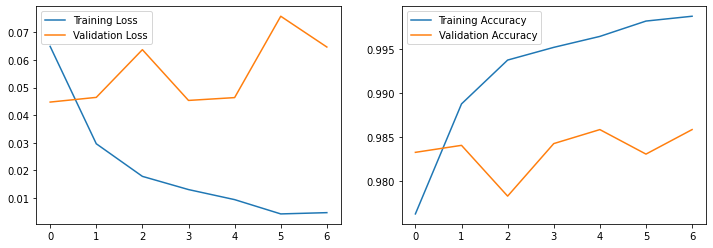

In [29]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [30]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 144.4MB 100kB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 256kB 36.4MB/s 
     |████████████████████████████████| 921kB 33.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=bef9c76ab1505925cb2d3eb38cbfdb4e270e68eda379cef09626a913c6e24e46
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation

In [0]:
saved_model_path = '/content/cats-dogs/models/model_5.h5'
output_path = '/content/cats-dogs/models/'

In [0]:
!tensorflowjs_converter --input_format=keras {saved_model_path} {output_path}

In [0]:
from google.colab import files
files.download('/content/cats-dogs/models/model.json') 

In [0]:
for i in range(1,7):
  files.download('/content/cats-dogs/models/group1-shard'+str(i)+'of6.bin')